# 4D emittance measurement analysis 

## Setup 

In [165]:
import sys
import os
from os.path import join
import copy
import importlib

import numpy as np
import pandas as pd
from scipy import optimize as opt
from scipy import integrate
from scipy import interpolate
from skimage import filters
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib.lines import Line2D
import proplot as pplt
import seaborn as sns
from tqdm import trange
from tqdm import tqdm

sys.path.append('/Users/46h/Research/')
from scdist.coupling import coupling as BL
from scdist.measurement import analysis
from scdist.measurement import pta
from scdist.measurement import tis
from scdist.measurement.plotting import reconstruction_lines
from scdist.tools import beam_analysis as ba
from scdist.tools import plotting as myplt
from scdist.tools import utils
from scdist.tools.ap_utils import phase_adv_matrix
from scdist.tools.ap_utils import V_matrix_4x4_uncoupled

Clear the output folder.

In [183]:
utils.delete_files_not_folders('_output/figures/')

ProPlot configuration.

In [184]:
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'
pplt.rc['figure.facecolor'] = 'white'
pplt.rc['grid'] = False
pplt.rc['grid.alpha'] = 0.04

Plot settings.

In [185]:
# Some labels.
ws_dims = ['x', 'y', 'u']
phase_space_labels = ["x [mm]", "x' [mrad]", "y [mm]", "y' [mrad]"]
emittance_labels = [
    r'$\varepsilon_x$', 
    r'$\varepsilon_y$', 
    r'$\varepsilon_1$', 
    r'$\varepsilon_2$'
]
# Extend x limits beyond last data point.
xlim_frac_pad = 1.05 

# Key word arguments for `ax.plot`.
lineplt_kws = dict(marker='.', alpha=1.0)

# Key word arguments for `ax.errorbar`.
elinewidth = 1.2
capsize = 1.75
ebar_lineplt_kws = lineplt_kws.copy()
ebar_lineplt_kws['elinewidth'] = elinewidth
ebar_lineplt_kws['capsize'] = capsize

# Key word arguments for `ax.errorbar` (error bars only).
ebar_kws = dict(marker=None, lw=0, elinewidth=1.2, capsize=1.75, alpha=lineplt_kws['alpha'])

# Key word arguments `ax.format`.
format_kws = dict(ygrid=True, xgrid=False)

# Key word arguments for `plt.savefig`.
savefig_kws = dict()

# Key word argument for `plt.plot` for wire-scanner plots.
ws_plot_kws = dict(marker='.', ms=3, alpha=0.7)

## Data processing

Select the directory containing the data. Within this directory, there should be a 'profiles' directory containing the profiles, and a file 'info/transfer_mats.dat' containing the transfer matrices from the reconstruction location to the wire-scanner location on each measurement.

In [186]:
# folder = './_saved/2021-08-01/production_scan_phases/'
# folder = './_saved/2021-09-07/TBT_production_0.5ms/ramp_turns/'
# folder = './_saved/2021-09-07/TBT_SCBD_0.5ms/ramp_turns/'
folder = './_saved/2021-09-26/setting1/ramp_turns/'
# folder = './_saved/2021-10-21/setting2/injturns400/ramp_turns/'
# folder = './_saved/2022-03-01/'

Load the transfer matrices.

In [187]:
filename = os.path.join(folder, 'info/transfer_mats.dat')
tmats_dict = dict()
file = open(filename, 'r')
for line in file:
    tokens = line.rstrip().split(' ')
    ws_id = tokens[0]
    items = [float(token) for token in tokens[1:]]
    if ws_id not in tmats_dict:
        tmats_dict[ws_id] = []
    tmats_dict[ws_id].append(items)
file.close()

ws_ids = sorted(list(tmats_dict))
n_meas = len(tmats_dict[ws_ids[0]])
meas_indices = list(range(n_meas))

for ws_id in ws_ids:
    for i in range(n_meas):
        tmats_dict[ws_id][i] = np.reshape(tmats_dict[ws_id][i], (4, 4))

Load the wire-scanner profiles.

In [188]:
filenames = utils.list_files(os.path.join(folder, 'profiles/'))
measurements = pta.read_files(filenames)

CORRECT MISSING DATA POINT. In one of the measurements, there was a wire-scanner that had a missing data point. Only four profiles were used in the emittance reconstruction, which makes the reconstruction quite sensitive to the RMS widths estimated from the profiles. We therefore fill in the RMS width from the two neighboring measurements.

In [189]:
if folder == './_saved/2021-09-26/setting1/ramp_turns/':
    meas_index_bad = -2
    ibad = 18
    measurement = measurements[meas_index_bad]
    for ws_id in ws_ids[:2]:
        profile = measurement[ws_id]
        signal = profile.dia
        signal.raw[ibad] = np.mean(signal.raw[[ibad - 1, ibad + 1]])
        signal.stats['Sigma'].rms = np.mean([
            measurements[meas_index_bad - 1][ws_id].dia.stats['Sigma'].rms,
            measurements[meas_index_bad + 1][ws_id].dia.stats['Sigma'].rms
        ])

If `xlabel` = 'Turn number', each measurement corresponds to a different turn number — hence a different beam; the correct turn numbers will need to be specified below. If `xlabel` = 'Measurement index', then each measurement corresponds to the same beam with a different set of optics. 

In [190]:
xlabel = 'Turn number' # {'Turn number', 'Measurement index'}

if xlabel == 'Turn number':
    xvals = list(range(50, 550, 50))
elif xlabel == 'Measurement index':
    xvals = meas_indices
else:
    raise ValueError('Fix `xlabel`.')

## Wire-scanner profiles 

In [191]:
width = 2.0 * 3.5
width_units = 'std' # {None, 'std'}
n_interp = None

Waterfall plot.

In [ ]:
fig, axes = pplt.subplots(nrows=4, ncols=3, figwidth=6.0, figheight=6.0, spanx=False)
for row, ws_id in enumerate(ws_ids):
    color = pplt.Cycle('538').by_key()['color'][row]
    pos_list, data_list = [], []
    for dim in ws_dims:
        pos, data = pta.processed_profiles(
            measurements, ws_id, dim, width, width_units, n_interp,
        )
        pos_list.append(pos)
        data_list.append(data)
    offset = 0.2 * max([np.max(data) for data in data_list])
    for dim, pos, data, ax in zip(ws_dims, pos_list, data_list, axes[row, :]):    
        offsets = np.array([i * offset for i in range(len(data))])
        data_offset = data + offsets[:, np.newaxis]
        ax.plot(pos, data_offset.T, marker=None, ms=2, color='black', cycle=None)
xmax = np.max(np.abs(pos_list))
axes.format(
    xlim=(-xmax, xmax), 
    yticks=[],
    leftlabels=ws_ids, 
    leftlabels_kw=dict(fontsize='small')
)
for ax, dim in zip(axes[-1, :], ws_dims):
    ax.set_xlabel(dim + ' [mm]')
plt.savefig('_output/figures/wireplot', **savefig_kws)
plt.show()

In [ ]:
fig, axes = pplt.subplots(nrows=3, ncols=4, figsize=(8.25, 5.5), spany=False)
for col, ws_id in enumerate(ws_ids):
    pos_list, data_list = [], []
    for dim in ws_dims:
        xlims = {'x': xlim_x, 'y': xlim_y, 'u': xlim_u}[dim]
        pos, data = pta.processed_profiles(measurements, ws_id, dim=dim,
                                           width=width, norm=False, n_interp=200)
        pos_list.append(pos)
        data_list.append(data)
    offset = 0.2 * max([np.max(data) for data in data_list])
    for dim, pos, data, ax in zip(ws_dims, pos_list, data_list, axes[:, col]):    
        offsets = np.array([i * offset for i in range(len(data))])
        data_offset = data + offsets[:, np.newaxis]
        ax.plot(data_offset.T, pos, marker=None, ms=2, 
                cycle='flare')
xmax = np.max(np.abs(pos_list))
axes.format(ylim=(-xmax, xmax), xticks=[],
            toplabels=ws_ids, toplabels_kw=dict(fontsize='small'))
for ax, dim in zip(axes[:, 0], ws_dims):
    ax.set_ylabel(dim + ' [mm]')

for j, xmax in enumerate(xmaxs):
    axes[j, :].format(ylim=(-xmax, xmax))
plt.savefig('_output/figures/wireplot2.png', **savefig_kws)
plt.show()

In [ ]:
measurements = list(reversed(measurements[:-1]))

In [ ]:
for meas_index, measurement in enumerate(measurements):
    fig, axes = pplt.subplots(nrows=4, ncols=3, figsize=(6.0, 5.0), spanx=False, space=None)
    max_sigma = 0.0
    for j in range(3):
        for i, ws_id in enumerate(ws_ids):
            ax = axes[i, j]
            profile = measurement[ws_id]
            signal = [profile.hor, profile.ver, profile.dia][j]
            x_meas = np.copy(signal.pos) - signal.stats['Mean'].rms    
            f_meas = np.copy(signal.raw) / signal.stats['Area'].rms

            x_fit = np.linspace(min(x_meas), max(x_meas), 1000)
            sigma_norm_fit = signal.stats['Sigma'].rms
            R_unif_fit = 2.0 * sigma_norm_fit
            max_sigma = max(max_sigma, sigma_norm_fit)
            f_unif = np.array([analysis.unif_dist(x, R_unif_fit) for x in x_fit])
            f_norm = np.array([analysis.norm_dist(x, sigma_norm_fit) for x in x_fit])
            alpha = 0.75
            ax.plot(x_fit, f_unif, color='blue8', alpha=alpha)
            ax.plot(x_fit, f_norm, color='red8', alpha=alpha)
            ax.plot(x_meas, f_meas, marker='.', ms=3, lw=0, color='black')

    xmax = 3.0 * max_sigma
    axes.format(xlim=(-xmax, xmax), yticklabelsize='small',
                leftlabels=ws_ids, leftlabels_kw=dict(fontsize='small'))
    for ax, dim in zip(axes[-1, :], ws_dims):
        ax.set_xlabel(dim + ' [mm]')
    plt.savefig('_output/figures/fits_{}'.format(meas_index))
    plt.show()

In [ ]:
for meas_index, measurement in enumerate(measurements):
    fig, axes = pplt.subplots(nrows=4, ncols=3, figsize=(5.0, 5.0), spanx=False, space=None)
    max_sigma = 0.0
    for j in range(3):
        for i, ws_id in enumerate(ws_ids):
            ax = axes[i, j]
            profile = measurement[ws_id]
            signal = [profile.hor, profile.ver, profile.dia][j]
            x_meas = np.copy(signal.pos) - signal.stats['Mean'].rms    
            f_meas = np.copy(signal.raw) / signal.stats['Area'].rms

            x_fit = np.linspace(min(x_meas), max(x_meas), 1000)

            sigma_norm_fit = signal.stats['Sigma'].rms
            R_unif_fit = 2.0 * sigma_norm_fit
            max_sigma = max(max_sigma, sigma_norm_fit)

            f_unif = np.array([unif_dist(x, R_unif_fit) for x in x_fit])
            f_norm = np.array([norm_dist(x, sigma_norm_fit) for x in x_fit])
            alpha = 0.75
            ax.plot(x_fit, f_unif, color='blue8', alpha=alpha)
            ax.plot(x_fit, f_norm, color='red8', alpha=alpha)
            ax.plot(x_meas, f_meas, marker='.', ms=3, lw=0, color='black')

    xmax = 3.0 * max_sigma
    axes.format(xlim=(-xmax, xmax), yticklabelsize='small',
                leftlabels=ws_ids, leftlabels_kw=dict(fontsize='small'))
    for ax, dim in zip(axes[-1, :], ws_dims):
        ax.set_xlabel(dim + ' [mm]')
    plt.savefig('_output/figures/fits_{}.png'.format(meas_index), **savefig_kws)
    plt.show()

In [ ]:
colors = pplt.Cycle(pplt.Colormap('flare')).by_key()['color']

In [ ]:
# from mpl_toolkits.mplot3d import axes3d
# import matplotlib.pyplot as plt

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d', azim=-90, elev=30)

# # Plot a basic wireframe.
# X, Y = np.meshgrid(pos, xvals)
# Z = data
# ax.plot_wireframe(X, Y, Z, ccount=0, edgecolors=colors)
# ax.grid(False)

# plt.show()

In [ ]:
for same_ylim in [False, True]:
    # Get global maximum signal height.
    ymax = 0.
    for meas_index in range(n_meas):
        measurement = measurements[meas_index]
        for ws_id in ws_ids:
            fx = measurement[ws_id].hor.raw
            fy = measurement[ws_id].ver.raw
            fu = measurement[ws_id].dia.raw            
            ymax = max(ymax, max(np.max(fx), np.max(fy), np.max(fu)))

    for meas_index in range(n_meas):
        measurement = measurements[meas_index]
        fig, axes = pplt.subplots(ncols=3, figsize=(8, 2.0), sharex=False)
        axes.format(cycle='538', rc_kw={'legend.fontsize': 5}, **format_kws)
        handles = []
        for ws_id in ws_ids:
            axes[0].plot(measurement[ws_id].hor.pos, measurement[ws_id].hor.raw, **ws_plot_kws)
            axes[1].plot(measurement[ws_id].ver.pos, measurement[ws_id].ver.raw, **ws_plot_kws)
            g = axes[2].plot(measurement[ws_id].dia.pos, measurement[ws_id].dia.raw, **ws_plot_kws)            
            handles.append(g)
        axes[0].format(xlabel='x [mm]')
        axes[1].format(xlabel='y [mm]')
        axes[2].format(xlabel='u [mm]')
        if same_ylim:
            ymin = axes[0].get_ylim()[0]
            axes.format(ylim=(ymin, ymax))
        axes[0].set_xlim(xlim_x)
        axes[1].set_xlim(xlim_y)
        axes[2].set_xlim(xlim_u)
        axes[2].legend(handles, labels=ws_ids, ncols=1, loc='r')
        
        if xlabel == 'Turn number':
            plt.suptitle('Turn = {}'.format(xvals[meas_index]))
        else:
            plt.suptitle('Measurement index = {}'.format(meas_index))
        
        if same_ylim:
            figname = '_output/figures/profiles_sameylim_{}.png'.format(meas_index)
        else:
            figname = '_output/figures/profiles_{}.png'.format(meas_index)
        plt.savefig(figname, **savefig_kws)
        plt.show()
        
    print()
    print()

In [ ]:
width = 3.5
norm = False

In [ ]:
# for ws_id in ws_ids:
#     fig, axes = pplt.subplots(ncols=3, figsize=(8.25, 2.0), spanx=False)
#     for ax, dim in zip(axes, dims):
#         pos, data = pta.processed_profiles(measurements, ws_id, dim=dim, 
#                                            width=width, norm=norm, n_interp=200)
#         ax.pcolormesh(pos, xvals, data, cmap='viridis', ec='none')        
#         ax.set_xlabel('{} [mm]'.format(dim))
#     plt.suptitle('{}'.format(ws_id), fontsize='medium')
#     axes.format(ylabel=xlabel, ytickminor=False)
#     plt.savefig('_output/figures/waterfall_heatmap_{}.png'.format(ws_id), **savefig_kws)
#     plt.show()

In [ ]:
pos_mins = 3 * [+np.inf]
pos_maxs = 3 * [-np.inf]
cmap = 'viridis'
fig, axes = pplt.subplots(nrows=4, ncols=3, figsize=(8.25, 6.1), spanx=False)
for row, ws_id in enumerate(ws_ids):
    for col, (ax, dim) in enumerate(zip(axes[row, :], dims)):
        pos, data = pta.processed_profiles(measurements, ws_id, dim=dim, 
                                           width=width, norm=norm, n_interp=200)
        pos_mins[col] = min(np.min(pos), pos_mins[col])
        pos_maxs[col] = max(np.max(pos), pos_maxs[col])
        # Make the background match.
        ax.pcolormesh(np.linspace(0, 500, 100), xvals, np.zeros((len(xvals), 100)), cmap=cmap) 
        ax.pcolormesh(pos, xvals, data, cmap=pplt.Colormap(cmap), ec='none')        
        ax.set_xlabel('{} [mm]'.format(dim))
axes.format(ylabel=xlabel, ytickminor=False, 
            leftlabels=ws_ids, leftlabels_kw=dict(fontsize='small'))
for col, (pos_min, pos_max) in enumerate(zip(pos_mins, pos_maxs)):
    axes[:, col].format(xlim=(pos_min, pos_max))
plt.savefig('_output/figures/waterfall_heatmap_combined_{}.png'.format(cmap), **savefig_kws)
plt.show()

In [ ]:
line_kws = dict(color='black', marker='.', ms=0)
for ws_id in ws_ids:
    fig, axes = pplt.subplots(ncols=3, figsize=(4.5, 4), spanx=False)
    for ax, dim in zip(axes, dims):
        pos, data = pta.processed_profiles(measurements, ws_id, dim=dim, 
                                           width=width, norm=norm)
        for i in range(len(data)):
            offset = xvals[i]
            scale = 100.
            ax.plot(pos, offset + scale * data[i], **line_kws)
        ax.set_xlabel('{} [mm]'.format(dim))
    axes.format(ylabel=xlabel, ytickminor=False)
    plt.suptitle('{}'.format(ws_id), fontsize='medium')
    plt.savefig('_output/figures/waterfall_{}.png'.format(ws_id), **savefig_kws)
    plt.show()

Extract the estimated moments from the wire-scanner measurements.

In [192]:
moments_dict = dict() # [<xx>, <yy>, <uu>, <xy>]
for ws_id in ws_ids:
    moments = []
    for measurement in measurements:
        sig_xx = measurement[ws_id].hor.stats['Sigma'].rms**2
        sig_yy = measurement[ws_id].ver.stats['Sigma'].rms**2
        sig_uu = measurement[ws_id].dia.stats['Sigma'].rms**2
        sig_xy = sig_uu - 0.5 * (sig_xx + sig_yy)
        moments.append([sig_xx, sig_yy, sig_uu, sig_xy])
    moments_dict[ws_id] = np.array(moments)

Compute the rms values from squared moments.

In [193]:
rms_dict = dict() # [xrms, yrms, urms]
for ws_id in ws_ids:
    moments = moments_dict[ws_id]
    rms_dict[ws_id] = np.sqrt(moments[:, :3])

Compute the x-y correlation coefficient.

In [194]:
xy_corr_coef_dict = dict() # [<xy> / (xrms * yrms)]
for ws_id in ws_ids:
    moments = moments_dict[ws_id]
    xy_corr_coef_dict[ws_id] = moments[:, 3] / np.sqrt(moments[:, 0] * moments[:, 1]) 

Repeated wire-scanner measurements have shown around a 2% variation in the squared moments.

In [195]:
frac_err = 0.03
moments_err_dict = dict()
for ws_id in ws_ids:
    moments = moments_dict[ws_id]
    moments_err = np.zeros(moments.shape)    
    moments_err[:, :3] = frac_err * moments[:, :3]
    moments_err[:, 3] = np.sqrt(moments_err[:, 2]**2 + 0.25 * (moments_err[:, 0]**2 + moments_err[:, 1]**2))
    moments_err_dict[ws_id] = moments_err

In [196]:
rms_err_dict = dict()
for ws_id in ws_ids:
    moments = moments_dict[ws_id]
    moments_err = moments_err_dict[ws_id]
    rms = rms_dict[ws_id]    
    rms_err_dict[ws_id] = 0.5 * moments_err[:, :3] / rms

In [197]:
xy_corr_coef_err_dict = dict()
for ws_id in ws_ids:
    moments = moments_dict[ws_id]
    moments_err = moments_err_dict[ws_id]
    xy_corr_coef_err_dict[ws_id] = analysis.get_corr_coef_err(moments[:, 0], moments[:, 1], moments[:, 3], 
                                                              moments_err[:, 0], moments_err[:, 1], moments_err[:, 3])

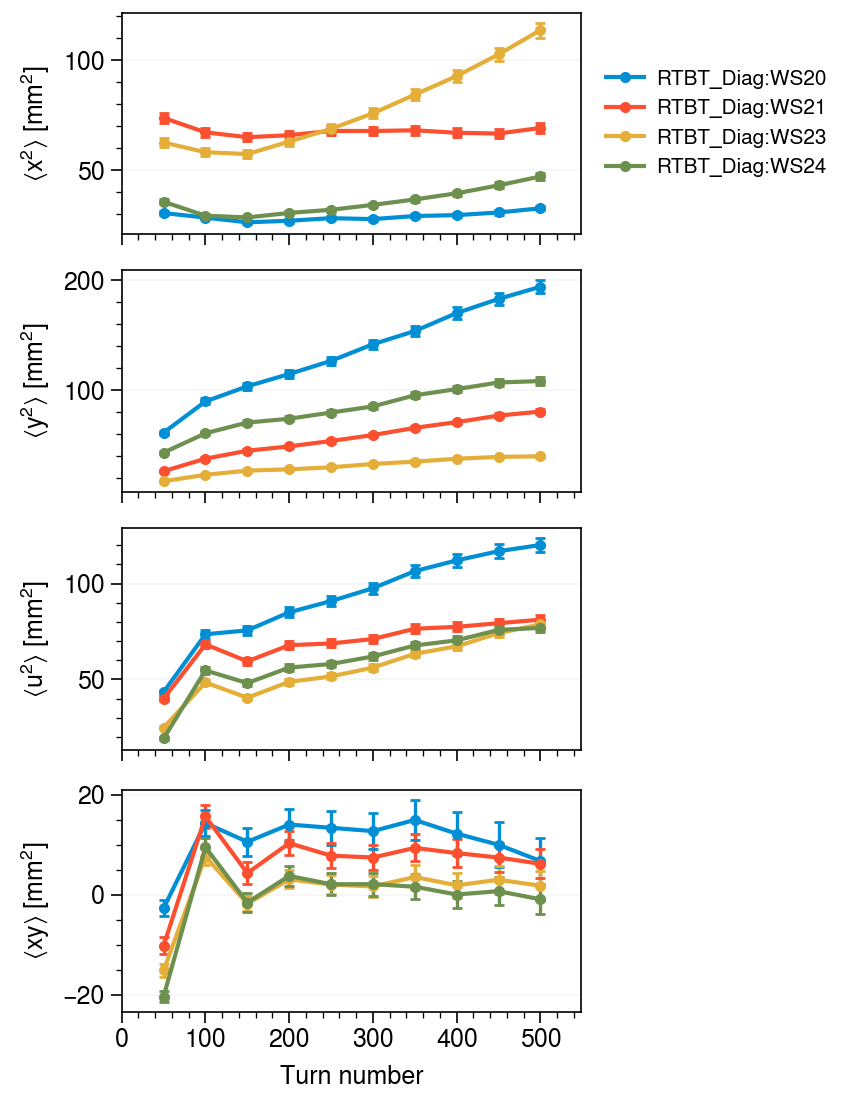

In [85]:
with pplt.rc.context(legendfontsize='small'):
    fig, axes = pplt.subplots(nrows=4, figsize=(4.25, 5.5), spany=False, aligny=True)
    axes.format(cycle='538')
    handles = []
    for ws_id in ws_ids:    
        moments = moments_dict[ws_id]
        moments_err = moments_err_dict[ws_id]
        for i in range(4):
            ebars = axes[i].errorbar(xvals, moments[:, i], yerr=moments_err[:, i], **ebar_lineplt_kws)
        data_line, caplines, barlinecols = ebars
        handles.append(data_line)
    axes[0].legend(handles, labels=ws_ids, ncols=1, loc='r', framealpha=0.)
    axes[0].format(ylabel=r'$\langle{x^2}\rangle$ [mm$^2$]')
    axes[1].format(ylabel=r'$\langle{y^2}\rangle$ [mm$^2$]')
    axes[2].format(ylabel=r'$\langle{u^2}\rangle$ [mm$^2$]')
    axes[3].format(ylabel=r'$\langle{xy}\rangle$ [mm$^2$]')
    axes.format(xlabel=xlabel, **format_kws)
    axes.format(xlim=(0, xlim_frac_pad * axes[0].get_xlim()[1]))
    plt.savefig('_output/figures/moments_vert')

In [ ]:
with pplt.rc.context(legendfontsize='small'):
    
    fig, axes = pplt.subplots([[1, 2, 3], [None, None, 4]], figsize=(8.0, 3.5), sharey=False)
    axes.format(cycle='538')
    handles = []
    for ws_id in ws_ids:    
        moments = moments_dict[ws_id]
        moments_err = moments_err_dict[ws_id]
        for i in range(4):
            ebars = axes[i].errorbar(xvals, moments[:, i], yerr=moments_err[:, i], **ebar_lineplt_kws)
        data_line, caplines, barlinecols = ebars
        handles.append(data_line)
    axes[0].legend(handles, labels=ws_ids, ncols=1, loc=(0, -0.95), framealpha=0.)
    axes[0].format(ylabel=r'$\langle{x^2}\rangle$ [mm$^2$]')
    axes[1].format(ylabel=r'$\langle{y^2}\rangle$ [mm$^2$]')
    axes[2].format(ylabel=r'$\langle{u^2}\rangle$ [mm$^2$]')
    axes[3].format(ylabel=r'$\langle{xy}\rangle$ [mm$^2$]')
    
    ymax = max(ax.get_ylim()[1] for ax in axes[:3])
    for ax in axes[:3]:
        ax.set_ylim(0., ymax)
    ymax = max(np.abs(axes[3].get_ylim()))
    axes[3].set_ylim(-ymax, ymax)
    axes[0].set_xlim(0, xlim_frac_pad * axes[0].get_xlim()[1])
    
    axes.format(xlabel=xlabel, **format_kws)
    axes.format(xlim=(0, xlim_frac_pad * axes[0].get_xlim()[1]))
    plt.savefig('_output/figures/moments_stack')

In [ ]:
with pplt.rc.context(legendfontsize='small'):
    
    fig, axes = pplt.subplots([[1, 2, 3], [None, None, 4]], figsize=(8.0, 3.5), sharey=False)
    axes.format(cycle='538')
    handles = []
    for ws_id in ws_ids:    
        rms = rms_dict[ws_id]
        rms_err = rms_err_dict[ws_id]
        xycorr = xy_corr_coef_dict[ws_id]
        xycorr_err = xy_corr_coef_err_dict[ws_id]
        for i in range(3):
            ebars = axes[i].errorbar(xvals, rms[:, i], yerr=rms_err[:, i], **ebar_lineplt_kws)
        data_line, caplines, barlinecols = ebars
        handles.append(data_line)
        axes[3].errorbar(xvals, xycorr, xycorr_err, **ebar_lineplt_kws)
    axes[0].legend(handles, labels=ws_ids, ncols=1, loc=(0, -0.95), framealpha=0.)
    axes[0].format(ylabel=r'$\sqrt{\langle{x^2}\rangle}$ [mm]')
    axes[1].format(ylabel=r'$\sqrt{\langle{y^2}\rangle}$ [mm]')
    axes[2].format(ylabel=r'$\sqrt{\langle{u^2}\rangle}$ [mm]')
    axes[3].format(ylabel='x-y corr. coef.')
    
    ymax = max(ax.get_ylim()[1] for ax in axes[:3])
    for ax in axes[:3]:
        ax.set_ylim(0., ymax)
    ymax = max(np.abs(axes[3].get_ylim()))
    axes[3].set_ylim(-ymax, ymax)
    axes[0].set_xlim(0, xlim_frac_pad * axes[0].get_xlim()[1])
    
    axes.format(xlabel=xlabel, **format_kws)
    axes.format(xlim=(0, xlim_frac_pad * axes[0].get_xlim()[1]))
    plt.savefig('_output/figures/corr_stack')

In [ ]:
with pplt.rc.context(legendfontsize='small'):
    fig, axes = pplt.subplots(nrows=4, figsize=(4.25, 5.5), spany=False, aligny=True)
    axes.format(cycle='538')
    handles = []
    for ws_id in ws_ids:    
        rms = moments_dict[ws_id]
        rms_err = moments_err_dict[ws_id]
        xycorr = xy_corr_coef_dict[ws_id]
        xycorr_err = xy_corr_coef_err_dict[ws_id]
        for i in range(3):
            ebars = axes[i].errorbar(xvals, rms[:, i], yerr=rms_err[:, i], **ebar_lineplt_kws)
        data_line, caplines, barlinecols = ebars
        handles.append(data_line)
        axes[3].errorbar(xvals, xycorr, xycorr_err, **ebar_lineplt_kws)
    axes[0].legend(handles, labels=ws_ids, ncols=1, loc='r')
    axes[0].format(ylabel=r'$\sqrt{\langle{x^2}\rangle}$ [mm]')
    axes[1].format(ylabel=r'$\sqrt{\langle{y^2}\rangle}$ [mm]')
    axes[2].format(ylabel=r'$\sqrt{\langle{u^2}\rangle}$ [mm]')
    axes[3].format(ylabel='x-y corr. coef.')
    axes.format(xlabel=xlabel, **format_kws)
    axes[0].set_xlim(0, xlim_frac_pad * axes[0].get_xlim()[1])
    plt.savefig('_output/figures/corr_vert')

In [ ]:
fig, axes = pplt.subplots(ncols=4, figsize=(10.0, 1.75), sharey=False)
axes.format(cycle='538')
for ws_id in ws_ids:
    moments = moments_dict[ws_id]
    moments_err = moments_err_dict[ws_id]
    for i in range(4):
        axes[i].errorbar(xvals, moments[:, i], yerr=moments_err[:, i], **ebar_lineplt_kws)    
axes[0].format(ylabel=r'$\langle{x^2}\rangle$ [mm$^2$]')
axes[1].format(ylabel=r'$\langle{y^2}\rangle$ [mm$^2$]')
axes[2].format(ylabel=r'$\langle{u^2}\rangle$ [mm$^2$]')
axes[3].format(ylabel=r'$\langle{xy}\rangle$ [mm$^2$]')
ymax = max(ax.get_ylim()[1] for ax in axes[:3])
for ax in axes[:3]:
    ax.set_ylim(0., ymax)
ymax = max(np.abs(axes[3].get_ylim()))
axes[3].set_ylim(-ymax, ymax)
axes.format(xlabel=xlabel, **format_kws)
axes[0].set_xlim(0, xlim_frac_pad * axes[0].get_xlim()[1])
plt.savefig('_output/figures/moments_hor.png', **savefig_kws)

In [ ]:
fig, axes = pplt.subplots(ncols=4, figsize=(10.0, 1.75), sharey=False)
axes.format(cycle='538')
for ws_id in ws_ids:
    moments = moments_dict[ws_id]
    moments_err = moments_err_dict[ws_id]
    xycorr = xy_corr_coef_dict[ws_id]
    xycorr_err = xy_corr_coef_err_dict[ws_id]
    for i in range(3):
        axes[i].errorbar(xvals, moments[:, i], yerr=moments_err[:, i], **ebar_lineplt_kws)      
    axes[3].errorbar(xvals, xycorr, yerr=xycorr_err, **ebar_lineplt_kws)
axes[0].format(ylabel=r'$\sqrt{\langle{x^2}\rangle}$ [mm]')
axes[1].format(ylabel=r'$\sqrt{\langle{y^2}\rangle}$ [mm]')
axes[2].format(ylabel=r'$\sqrt{\langle{u^2}\rangle}$ [mm]')
axes[3].format(ylabel='x-y corr. coef.')
ymax = max(ax.get_ylim()[1] for ax in axes[:3])
for ax in axes[:3]:
    ax.set_ylim(0., ymax)
ymax = max(np.abs(axes[3].get_ylim(   )))
axes[3].set_ylim(-ymax, ymax)
axes[0].set_xlim(0, xlim_frac_pad * axes[0].get_xlim()[1])
axes.format(xlabel=xlabel, **format_kws)
plt.savefig('_output/figures/corr_hor.png', **savefig_kws)

In [ ]:
fig, axes = pplt.subplots(ncols=4, figsize=(8, 2))
xmax = 0.
for ax, ws_id in zip(axes, ws_ids):
    ax.set_title(ws_id, fontsize='small')
    for sig_xx, sig_yy, sig_uu, sig_xy in moments_dict[ws_id]:
        angle, c1, c2 = ba._rms_ellipse_dims(sig_xx, sig_yy, sig_xy)
        xmax = max(xmax, c1, c2)
        myplt.ellipse(ax, c1, c2, angle)
xmax *= 1.5
axes.format(xlim=(-xmax, xmax), ylim=(-xmax, xmax), 
            xlabel='x [mm]', ylabel='y [mm]',
            suptitle='Measured rms ellipses in x-y plane')
plt.savefig('_output/figures/corr.png', **savefig_kws)

## Reconstruction

To estimate the uncertainty in the reconstructed parameters, we repeat the reconstruction multiple times with random noise added to the measured $\langle{xx}\rangle$, $\langle{yy}\rangle$, and $\langle{uu}\rangle$ within the 2% window. The error bar widths are calculated from the standard deviation across the trials, and the error bar centers are calculated from the mean across the trials.

In [198]:
n_trials = 5000
Sigma_list = [] # reconstructions from measurements
Sigmas_list = [] # reconstructions from noisy measurements
fails_list = [] # number of failed fits

for meas_index in meas_indices:
    moments = [moments_dict[ws_id][meas_index] for ws_id in ws_ids]
    moments = np.array(moments)
    transfer_matrices = [tmats_dict[ws_id][meas_index] for ws_id in ws_ids]
    
    Sigma, C = analysis.reconstruct(moments[:, [0, 1, 3]], transfer_matrices)
    Sigma_list.append(Sigma)
    
    Sigmas, fails = analysis.reconstruct_random_trials(moments[:, :3], transfer_matrices, frac_err, n_trials)
    Sigmas_list.append(Sigmas)
    fails_list.append(fails)

100%|██████████| 5000/5000 [00:02<00:00, 1959.08it/s]


In [199]:
print(fails_list)

[0.0001999600079984003, 0.00039984006397441024, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00039984006397441024, 0.0]


Compute the beam statistics from the reconstructed covariance matrices.

In [200]:
stats = ba.BeamStats()
stats.read_cov(Sigma_list)

For each measurement, compute the beam statistics for every covariance matrix in the random trials. 

In [201]:
mc_stats_list = []
for Sigmas in tqdm(Sigmas_list):
    mc_stats = ba.BeamStats()
    mc_stats.read_cov(Sigmas)
    mc_stats_list.append(mc_stats)

100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


Emittances

In [162]:
fig_kws = dict(figsize=(4.0, 2.5))
legend_kws=dict(loc='r', ncols=1, handlelength=1.5, framealpha=0.)

In [163]:
lineplt_kws['alpha'] = 1.0
ebar_kws['alpha'] = 1.0

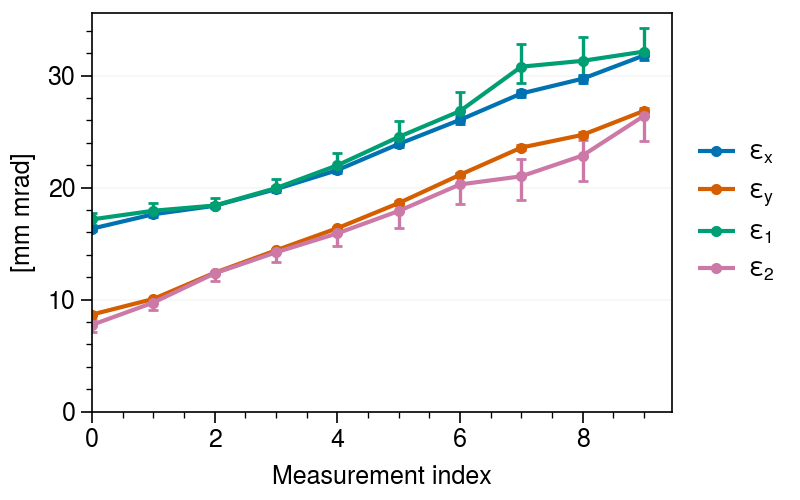

In [25]:
fig, ax = pplt.subplots(**fig_kws)
for col in ['eps_x', 'eps_y']:
    ax.errorbar(
        xvals, 
        [s.twiss2D[col].mean() for s in mc_stats_list], 
        yerr=[s.twiss2D[col].std() for s in mc_stats_list], 
        **ebar_kws,
    )
for col in ['eps_1', 'eps_2']:
    ax.errorbar(
        xvals, 
        [s.twiss4D[col].mean() for s in mc_stats_list], 
        yerr=[s.twiss4D[col].std() for s in mc_stats_list], 
        **ebar_kws,
    )
ax.format(cycle=pplt.rc['cycle'])
g1 = ax.plot(xvals, stats.twiss2D['eps_x'].values, **lineplt_kws)
g2 = ax.plot(xvals, stats.twiss2D['eps_y'].values, **lineplt_kws)
g3 = ax.plot(xvals, stats.twiss4D['eps_1'].values, **lineplt_kws)
g4 = ax.plot(xvals, stats.twiss4D['eps_2'].values, **lineplt_kws)
ax.legend([g1, g2, g3, g4], labels=emittance_labels, **legend_kws)
ax.format(
    xlabel=xlabel, ylabel='[mm mrad]', 
    ylim=(0., ax.get_ylim()[1]), 
    xlim=(0, xlim_frac_pad * ax.get_xlim()[1]),
    **format_kws
)
plt.savefig('_output/figures/emittance')
plt.show()

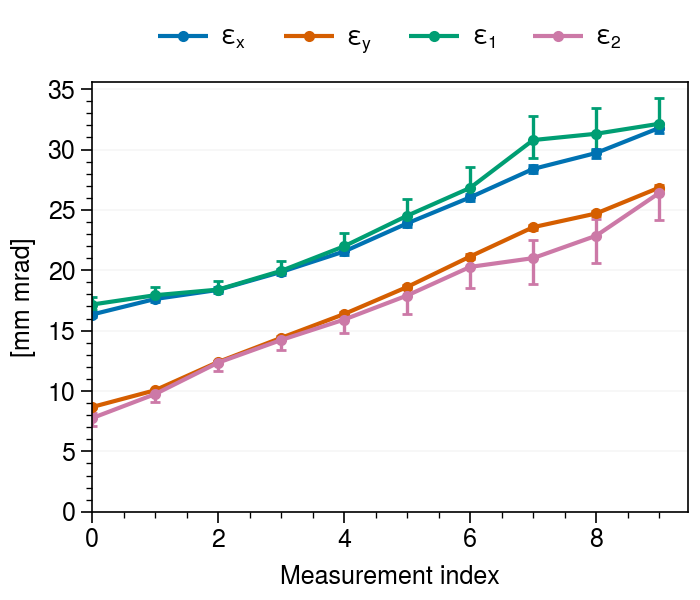

In [28]:
with pplt.rc.context(legendfontsize='medium'):
    fig, ax = pplt.subplots(figsize=(3.5, 3.0))
    for col in ['eps_x', 'eps_y']:
        ax.errorbar(
            xvals, 
            [s.twiss2D[col].mean() for s in mc_stats_list], 
            yerr=[s.twiss2D[col].std() for s in mc_stats_list], 
            **ebar_kws,
        )
    for col in ['eps_1', 'eps_2']:
        ax.errorbar(
            xvals, 
            [s.twiss4D[col].mean() for s in mc_stats_list], 
            yerr=[s.twiss4D[col].std() for s in mc_stats_list], 
            **ebar_kws,
        )
    ax.format(cycle=pplt.rc['cycle'])
    g1 = ax.plot(xvals, stats.twiss2D['eps_x'].values, **lineplt_kws)
    g2 = ax.plot(xvals, stats.twiss2D['eps_y'].values, **lineplt_kws)
    g3 = ax.plot(xvals, stats.twiss4D['eps_1'].values, **lineplt_kws)
    g4 = ax.plot(xvals, stats.twiss4D['eps_2'].values, **lineplt_kws)
    ax.legend([g1, g2, g3, g4], labels=emittance_labels, loc='t', ncols=4, framealpha=0., fontsize='small')
    ax.format(
        xlabel=xlabel, ylabel='[mm mrad]', 
        ylim=(0., ax.get_ylim()[1]), 
        xlim=(0, xlim_frac_pad * ax.get_xlim()[1]),
        **format_kws
    )
    plt.savefig('_output/figures/emittance2')
    plt.show()

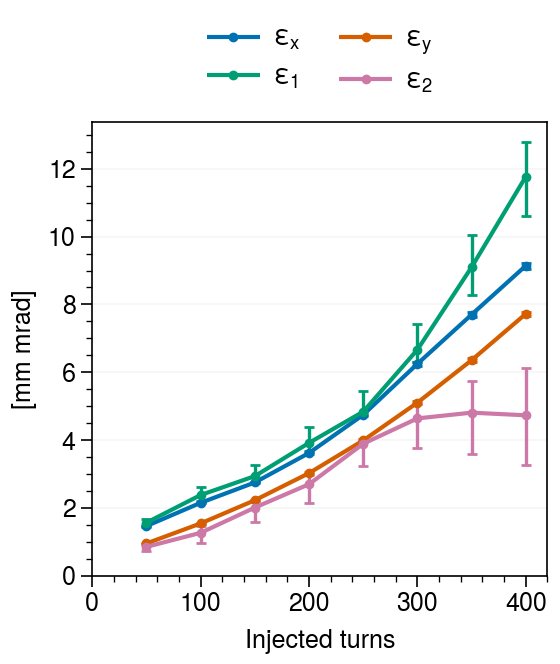

In [134]:
with pplt.rc.context(legendfontsize=9.5):
    fig, ax = pplt.subplots(figwidth=2.8)
    for col in ['eps_x', 'eps_y']:
        ax.errorbar(
            xvals, 
            [s.twiss2D[col].mean() for s in mc_stats_list], 
            yerr=[s.twiss2D[col].std() for s in mc_stats_list], 
            **ebar_kws,
        )
    for col in ['eps_1', 'eps_2']:
        ax.errorbar(
            xvals, 
            [s.twiss4D[col].mean() for s in mc_stats_list], 
            yerr=[s.twiss4D[col].std() for s in mc_stats_list], 
            **ebar_kws,
        )
    ax.format(cycle=pplt.rc['cycle'])
    lineplt_kws['ms'] = 5
    g1 = ax.plot(xvals, stats.twiss2D['eps_x'].values, **lineplt_kws)
    g2 = ax.plot(xvals, stats.twiss2D['eps_y'].values, **lineplt_kws)
    g3 = ax.plot(xvals, stats.twiss4D['eps_1'].values, **lineplt_kws)
    g4 = ax.plot(xvals, stats.twiss4D['eps_2'].values, **lineplt_kws)
    ax.legend([g1, g2, g3, g4], labels=emittance_labels, 
              loc='t', ncols=2, framealpha=0., 
#               fontsize='small'
             )
    ax.format(
        xlabel='Injected turns', ylabel='[mm mrad]', 
#         xlabel_kw=dict(fontsize='large'),
#         ylabel_kw=dict(fontsize='large'),
        ylim=(0., ax.get_ylim()[1]), 
        xlim=(0, xlim_frac_pad * ax.get_xlim()[1]),
        **format_kws
    )
    plt.savefig('_output/figures/emittance')
    plt.show()

In [202]:
eps_x = stats.twiss2D['eps_x'].values
eps_y = stats.twiss2D['eps_y'].values
eps_1 = stats.twiss4D['eps_1'].values
eps_2 = stats.twiss4D['eps_2'].values
meas = np.vstack([eps_x, eps_y, eps_1, eps_2]).T
eps_x_means = [mc_stats.twiss2D['eps_x'].mean() for mc_stats in mc_stats_list]
eps_y_means = [mc_stats.twiss2D['eps_y'].mean() for mc_stats in mc_stats_list]
eps_1_means = [mc_stats.twiss4D['eps_1'].mean() for mc_stats in mc_stats_list]
eps_2_means = [mc_stats.twiss4D['eps_2'].mean() for mc_stats in mc_stats_list]
means = np.vstack([eps_x_means, eps_y_means, eps_1_means, eps_2_means]).T
eps_x_stds = [mc_stats.twiss2D['eps_x'].std() for mc_stats in mc_stats_list]
eps_y_stds = [mc_stats.twiss2D['eps_y'].std() for mc_stats in mc_stats_list]
eps_1_stds = [mc_stats.twiss4D['eps_1'].std() for mc_stats in mc_stats_list]
eps_2_stds = [mc_stats.twiss4D['eps_2'].std() for mc_stats in mc_stats_list]
stds = np.vstack([eps_x_stds, eps_y_stds, eps_1_stds, eps_2_stds]).T

np.savetxt('_output/figures/meas.dat', meas)
np.savetxt('_output/figures/means.dat', means)
np.savetxt('_output/figures/stds.dat', stds)

In [ ]:
fig, ax = pplt.subplots(**fig_kws)
colors = ['red8', 'blue8']
for col, color in zip(['eps_4D', 'eps_4D_app'], colors):
    ax.errorbar(
        xvals, [s.twiss4D[col].mean() for s in mc_stats_list], 
        yerr=[s.twiss4D[col].std() for s in mc_stats_list], 
        color=color,
        **ebar_kws,
    )
g1 = ax.plot(xvals, stats.twiss4D['eps_4D'].values, color=colors[0], **lineplt_kws)
g2 = ax.plot(xvals, stats.twiss4D['eps_4D_app'].values, color=colors[1], **lineplt_kws)
ax.legend([g1, g2], labels=[r'$\varepsilon_1\varepsilon_2$', r'$\varepsilon_x\varepsilon_y$'], **legend_kws)
ax.format(
    xlabel=xlabel, ylabel=r'[mm$^2$ mrad$^2$]', 
    ylim=(0., ax.get_ylim()[1]), 
    xlim=(0, xlim_frac_pad * ax.get_xlim()[1]),
    **format_kws
)
plt.savefig('_output/figures/emittance4D')
plt.show()

Coupling coefficient

In [ ]:
fig, ax = pplt.subplots(**fig_kws)
ax.errorbar(
    xvals, [s.twiss4D['C'].mean() for s in mc_stats_list], 
    yerr=[s.twiss4D['C'].std() for s in mc_stats_list], 
    color='black',
    **ebar_kws,
    )
ax.plot(xvals, stats.twiss4D['C'].values, color='black', **lineplt_kws)
ax.format(
    xlabel=xlabel,
    title=r'$C = \sqrt{\frac{\varepsilon_x\varepsilon_y}{\varepsilon_1\varepsilon_2}}$',
    xlim=(0, xlim_frac_pad * ax.get_xlim()[1]),
    **format_kws
)
plt.savefig('_output/figures/C')
plt.show()

In [ ]:
for meas_index in meas_indices:
    mc_stats = mc_stats_list[meas_index]
    emittances_mc = pd.DataFrame()
    emittances_mc[[r'$\varepsilon_x$', r'$\varepsilon_y$']] = mc_stats.twiss2D[['eps_x', 'eps_y']]
    emittances_mc[[r'$\varepsilon_1$', r'$\varepsilon_2$']] = mc_stats.twiss4D[['eps_1', 'eps_2']]
    g = sns.pairplot(emittances_mc,
                     kind='hist', corner=False, height=1.25, 
                     diag_kws=dict(color='black'), 
                     plot_kws=dict(cmap=pplt.Colormap('mono', left=0.02)),
                    )

    eps_x_rec, eps_y_rec = stats.twiss2D.loc[meas_index, ['eps_x', 'eps_y']].values
    eps_1_rec, eps_2_rec = stats.twiss4D.loc[meas_index, ['eps_1', 'eps_2']].values
    emittances_rec = [eps_x_rec, eps_y_rec, eps_1_rec, eps_2_rec]
    for i in range(4):
        for j in range(4):
            if i != j:
                g.axes[i, j].scatter(emittances_rec[j], emittances_rec[i], c='red', s=10)
            else:
                g.diag_axes[j].axvline(emittances_rec[j], c='red')
    plt.suptitle('meas_index = {}'.format(meas_index))
#     plt.tight_layout()
    plt.savefig('_output/figures/eps_rand_{}'.format(meas_index))
    plt.show()

In [ ]:
fig, ax = pplt.subplots()
ax.bar(xvals, fails_list, color='black')
ax.format(xlabel=xlabel, ylabel='Number of failed fits', ylim=(0, ax.get_ylim()[1]))
plt.savefig('_output/figures/failed_fits')

2D Twiss parameters 

In [ ]:
fig, ax = pplt.subplots(figsize=(4.0, 2.5))
for col in ['beta_x', 'beta_y']:
    ax.errorbar(
        xvals, [s.twiss2D[col].mean() for s in mc_stats_list], 
        yerr=[s.twiss2D[col].std() for s in mc_stats_list], 
        **ebar_kws,
    )
ax.format(cycle=pplt.rc['cycle'])
g1 = ax.plot(xvals, stats.twiss2D['beta_x'].values, **lineplt_kws)
g2 = ax.plot(xvals, stats.twiss2D['beta_y'].values, **lineplt_kws)
ax.legend([g1, g2], labels=[r'$\beta_x$', r'$\beta_y$'], **legend_kws)
ax.format(
    xlabel=xlabel, ylabel='[m/rad]', 
    ylim=(0., ax.get_ylim()[1]), 
    xlim=(0, xlim_frac_pad * ax.get_xlim()[1]),
    **format_kws
)
plt.savefig('_output/figures/beta')
plt.show()

In [ ]:
fig, ax = pplt.subplots(figsize=(4.0, 2.5))
for col in ['alpha_x', 'alpha_y']:
    ax.errorbar(
        xvals, [s.twiss2D[col].mean() for s in mc_stats_list], 
        yerr=[s.twiss2D[col].std() for s in mc_stats_list], 
        **ebar_kws,
    )
ax.format(cycle=pplt.rc['cycle'])
g1 = ax.plot(xvals, stats.twiss2D['alpha_x'].values, **lineplt_kws)
g2 = ax.plot(xvals, stats.twiss2D['alpha_y'].values, **lineplt_kws)
ax.legend([g1, g2], labels=[r'$\alpha_x$', r'$\alpha_y$'], **legend_kws)
ymax = np.max(np.abs(ax.get_ylim()))
ax.format(
    xlabel=xlabel, ylabel='[rad]', 
    ylim=(-ymax, ymax),
    xlim=(0, xlim_frac_pad * ax.get_xlim()[1]),
    **format_kws
)
plt.savefig('_output/figures/alpha')
plt.show()

Reconstructed covariance ellipses.

In [ ]:
axes = myplt.rms_ellipses(Sigma_list, cmap=pplt.Colormap('flare'), constrained_layout=True, lw=1.25)
labels = ["x [mm]", "x' [mrad]", "y [mm]", "y' [mrad]"]
for i in range(3):
    axes[i, 0].set_ylabel(labels[i + 1])
    axes[-1, i].set_xlabel(labels[i])
xlims = [ax.get_xlim() for ax in axes[-1, :]]
ylims = [ax.get_ylim() for ax in axes[:, 0]]
plt.savefig('_output/figures/corner')
plt.show()

Mean covariance ellipses over the trials.

In [ ]:
axes = myplt.rms_ellipses(np.mean(Sigmas_list, axis=1), cmap=pplt.Colormap('flare'))
labels = ["x [mm]", "x' [mrad]", "y [mm]", "y' [mrad]"]
for i in range(3):
    axes[i, 0].set_ylabel(labels[i + 1])
    axes[-1, i].set_xlabel(labels[i])
plt.savefig('_output/figures/corner_mean.png', **savefig_kws)
plt.show()

## Target images 

In [ ]:
images = tis.read_files(
    utils.list_files(os.path.join(folder, 'target_images')), 
    make_square=False, # normal image follows target dimensions
    thresh=200, # image arrays must sum to at least `thresh` to be included (avoid blanks)
    n_avg=10 # number of images to average for each final image
)

In [ ]:
sigma = 4.0 # Gaussian blur
plot_kws = dict(cmap='mono_r')
ellipse_kws = dict(lw=0.3, alpha=0.75)
n_turns = xvals
image_moments = []

for i in range(len(images)):
    image = images[i]
    image.filter(sigma)

    fig, ax = pplt.subplots(figsize=(4.2, 2.0))

    # Plot the filtered image.
    ax.pcolormesh(image.xx, image.yy, image.Zf.T, **plot_kws)
    
    # Plot the rms ellipse calculated from the image. 
    mean_x, mean_y, sig_xx, sig_yy, sig_xy = image.estimate_moments(use_filtered=True)
    image_moments.append([sig_xx, sig_yy, sig_xy])
    angle, c1, c2 = ba._rms_ellipse_dims(sig_xx, sig_yy, sig_xy)
    myplt.ellipse(ax, 2.0 * c1, 2.0 * c2, angle, center=(mean_x, mean_y), color='blue8', **ellipse_kws)  

    # # Plot the wire-scanner measurement. This assumes the wire-scanner 
    # # reconstruction is at the target. 
    # Sigma = Sigma_list[i]
    # angle, c1, c2 = ba._rms_ellipse_dims(Sigma[0, 0], Sigma[2, 2], Sigma[0, 2])
    # myplt.ellipse(ax, 2.0 * c1, 2.0 * c2, angle, center=(mean_x, mean_y), 
    #               color='red8', **ellipse_kws)  
    
    # Formatting
    scale = 1.0
    xmax = scale * np.max(image.xx)
    ymax = scale * np.max(image.yy)
    ax.format(aspect=1.0, xlabel='x [mm]', ylabel='y [mm]',
              xlim=(-xmax, xmax), ylim=(-ymax, ymax),
              title='Turn {}'.format(n_turns[i])
             )
    plt.savefig('_output/figures/target_image_{}.png'.format(i), **savefig_kws)
    plt.show()

In [ ]:
image_moments = np.array(image_moments)

In [ ]:
fig, axes = pplt.subplots(ncols=3, figsize=(7.5, 1.75), sharey=False) 
color = 'black'
for i in range(3):
    axes[i].plot(image_moments[:, i], color='black', **lineplt_kws)
axes[0].format(ylabel=r'$\langle{x^2}\rangle$ [mm$^2$]')
axes[1].format(ylabel=r'$\langle{y^2}\rangle$ [mm$^2$]')
axes[2].format(ylabel=r'$\langle{xy}\rangle$ [mm$^2$]')
ymax = max(ax.get_ylim()[1] for ax in axes[:2])
for ax in axes[:2]:
    ax.set_ylim(0., ymax)
ymax = max(np.abs(axes[2].get_ylim()))
axes[2].set_ylim(-ymax, ymax)
axes.format(xlabel=xlabel, **format_kws)
plt.savefig('_output/figures/image_moments_hor.png', **savefig_kws)

In [ ]:
fig, axes = pplt.subplots(ncols=3, figsize=(7.5, 1.75), sharey=False, sharex=True) 
color = 'black'
axes[0].plot(xvals, np.sqrt(image_moments[:, 0]), color='black', **lineplt_kws)
axes[1].plot(xvals, np.sqrt(image_moments[:, 0]), color='black', **lineplt_kws)
axes[2].plot(xvals, image_moments[:, 2] / np.sqrt(image_moments[:, 0] * image_moments[:, 1]), color='black', **lineplt_kws)
axes[0].format(ylabel=r'$\sqrt{\langle{x^2}\rangle}$ [mm]')
axes[1].format(ylabel=r'$\sqrt{\langle{y^2}\rangle}$ [mm]')
axes[2].format(ylabel='x-y corr. coef.')
ymax = max(ax.get_ylim()[1] for ax in axes[:2])
for ax in axes[:2]:
    ax.set_ylim(0., ymax)
ymax = max(np.abs(axes[2].get_ylim()))
axes[2].set_ylim(-ymax, ymax)
axes.format(xlim=(0., xlim_frac_pad * axes[0].get_xlim()[1]))
axes.format(xlabel=xlabel, **format_kws)
plt.savefig('_output/figures/image_rms_hor.png', **savefig_kws)